# 08. PyTorch Paper Replicating.

**The goal of machine learning research paper replicating is: turn a ML research paper into usuable code.**

In this notebook, I am going to be replicating the Vision Transformer (ViT) [architecture/paper](https://arxiv.org/abs/2010.11929) with PyTorch.


This notebook is fully followed from the greatest [course](https://zerotomastery.io/courses/learn-pytorch/) by [Daniel Bourke](https://www.linkedin.com/in/mrdbourke/)

The Book version of the course is [here](https://www.learnpytorch.io/08_pytorch_paper_replicating/)


# Get Setup

Now I am going to import the necessary libraries

In [1]:
import matplotlib.pyplot as plt
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torchmetrics import Accuracy

try:
    from torchinfo import summary
except:
    print(f"[INFO] Couldn't find the torchinfo...\n Installing it.....")
    %pip install -qq torchinfo
    from torchinfo import summary

# Try to import going_moduler directory. download it from GitHub, if it doesn't work
try:
    print(f"[INFO] Trying to find the going_modular directory.....")
    from going_modular import data_setup, engine, utils
except:
    print(f"[INFO] Couldn't find the directory...\n Downloading it from github.....")
    !git clone https://github.com/Niloy009/learning_pytorch.git
    !mv leaning_pytorch/going_modular .
    !rm -rf learning_pytorch
    from going_modular import data_setup, engine, utils




[INFO] Trying to find the going_modular directory.....


In [2]:
# Setup device agnostic code

device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
device

'mps'

# Get the Data

Download the data if not exist and unzip it.

In [3]:
import os
from pathlib import Path
import zipfile
import requests

def download_data(source: str, destination: str, remove_source: bool= True) -> Path:
    """Download a ziped dataset from source and unzip to destination

    Args:
        source: The source path where the data will download from.
        destination: The destination path where the data will download and unzip to.
        remove_source: Whether the source remove or not after download.
        
    Returns:
        pathlib.Path to downloaded data.
    """

    # Setup the data path
    data_path = Path("data/")
    image_path = data_path / destination

    # If image folder is not exist, then prepare it and download the data
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping re-download")
    else:
        print(f"[INFO] {image_path} doesn't exist. Downloading it.....")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download the data..
        target_file = Path(source).name
        with open(file=data_path / target_file , mode='wb') as file:
            request = requests.get(url=source)
            print(f"[INFO] Downloading {target_file} from {source}.....")
            file.write(request.content)
            
        # Unzip the folder
        with zipfile.ZipFile(data_path / target_file, mode='r') as zip_ref:
            print(f"[INFO] Unzipping {target_file} file......")
            zip_ref.extractall(path=image_path)

        # Remove the zip folder
        if remove_source:
            os.remove(data_path / target_file)
    
    return image_path


In [4]:
image_data_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip", 
              destination="pizza_steak_sushi")
image_data_path

[INFO] data/pizza_steak_sushi directory exists, skipping re-download


PosixPath('data/pizza_steak_sushi')

In [5]:
# Setup directory paths to train and test images
train_dir = image_data_path / 'train'
test_dir = image_data_path / 'test'

In [6]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# Create Datasets and DataLoaders

In [7]:
# Create image size (from table 3 on ViT paper)
IMAGE_SIZE = 224

# Create transforms pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor()
])
print(f"manually created transforms: {manual_transforms}")


manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [8]:
# Create batch size (the paper used 4096 but I am stick with 32 to start with small)
BATCH_SIZE = 32

train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms,
                                                                               batch_size=BATCH_SIZE)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

# Visualize a single image

In [9]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get the single image and label
image , label = image_batch[0], label_batch[0]

# Get the shape of the image and label
image.shape, label

/Users/niloy_saha/anaconda3/envs/torch/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


(torch.Size([3, 224, 224]), tensor(1))

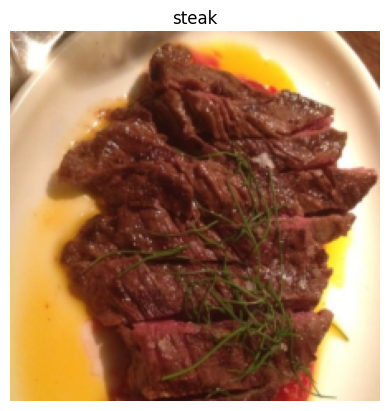

In [10]:
# Plot the image and its label
plt.imshow(image.permute(1,2,0)) # color_channel, height, width -> height, width, color_channel
plt.title(class_names[label])
plt.axis(False);


# Replicating ViT: Overview

Looking at a whole machine learning research paper can be imtimidating.

So in order to make it more understandable, we can break it down into smaller pieces:

* **Inputs** - What goes into the model? (in this case, image tensors)
* **Outputs** - What comes out of the model/layer/block? (in our case. we want the model to output image classification labels)
* **Layers** - Takes an input, manipulates it with a function. (i.e. could be self-attention)
* **Blocks** - A collection of layers
* **Model** - A collection of blocks

### ViT overview: pieces of the puzzle

* Figure 1: Visual overview of the architecture
* Four Equations: math equations which define the functions of eacher layer/block.
* Tabel 1/3: different hyperparameters for the architecture/training.
* Text Description (especially chapter 3.1 on paper)

#### Figure 1
![](./paper/images/Figure_1_model_architecture_edited.png)

* **Embedding:** Learnable representation (start with random number and improve over time)



#### Four Equations
![](./paper/images/Equations.png)

#### Section 3.1 Describes the various equations

**Equation 1:**

An overview of the model is depicted in Figure 1. The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_p \in \mathbb{R}^{N \times\left(P^2 \cdot C\right)}$, where ( $H, W$ ) is the resolution of the original image, $C$ is the number of channels, ( $P, P$ ) is the resolution of each image patch, and $N=H W / P^2$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1 ). We refer to the output of this projection as the patch embeddings.

**Equation 1:**

Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

In pseudo code:
```python
# Equation 1
x_input = [class_token, image_patch_1, image_patch_2, ... image_patch_N] + [class_token_pos, image_patch_1_pos, image_patch_2_pos, ... image_patch_N_pos]
```


**Equation 2, 3:**

The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski \& Auli, 2019).

In pseudo code:

```python
# Equation 2
x_output_MSA_block = MSA_layer(LN_layer(x_input)) + x_input

# Equation 3
x_ouput_MLP_block = MLP_layer(Ln_layer(x_output_MSA_block)) + x_output_MSA_block
```


**Equation 4:**

Similar to BERT's [class] token, we prepend a learnable embedding to the sequence of embedded patches ( $\mathbf{z}_0^0=\mathbf{x}_{\text {class }}$ ), whose state at the output of the Transformer encoder ( $\mathbf{z}_L^0$ ) serves as the image representation $\mathbf{y}$ (Eq. 4). Both during pre-training and fine-tuning, a classification head is attached to $\mathbf{z}_L^0$. The classification head is implemented by a MLP with one hidden layer at pre-training time and by a single linear layer at fine-tuning time.

* MLP: Multi Layer Preceptron -> a neural network with X number of layers.
* MLP: One hidden layer at **pre-training** time.
* MLP: Single linear layer at **fine-tuning** time.

In pseudo code:

```python
# Equation 4
y = Linear_layer(LN_layer(x_ouput_MLP_block))
```


#### Table 1
![](./paper/images/Table_1.png)

* ViT-Base, ViT-Large, ViT-Huge are all the same model architecture with different sizes.
* **ViT-B/16** - ViT-Base Model with patch size ${16\times16}$ 
* **Layers** - The number of transformer encode layers.
* **Hidden size $D$** - The embeding size throughout the architecture.
* **MLP size** - The number of hidden units/neurons in the MLP.
* **Heads** - The number of multi-head self-attention.

 ## 4. Equation 1: Split data into patches and creating the class, position and patch embedding.

 First I want to know what is my input shape and output shape:

 * Input Shape: ${H \times W \times C}$ -> Height, Width, Color Channels
 * Output Shape: ${N \times (P^2 \cdot C)}$
 * H: Height
 * W: Width
 * C: Color Channel
 * P: Patch Size
 * N: Number of Patch Size -> ${(Height \times Width) / P^2}$
 * D: Constant latent vector size -> **embedding dimension** (see table 1)

In [11]:
# Create Examples
height = 224
width = 224
color_channels = 3
patch_size = 16

# Calculate number of patches
num_patches = int((height * width) / (patch_size ** 2))
print(f"Number of patches: {num_patches}")

Number of patches: 196


In [12]:
# Input Shape
embedding_layer_input_shape = (height, width, color_channels)

# Output Shape
embedding_layer_output_shape = (num_patches, patch_size **2 * color_channels)

print(f"Input Shape (Single 2D Image): {embedding_layer_input_shape}")
print(f"Output Shape (Single 1D sequence of patches): {embedding_layer_output_shape}")

Input Shape (Single 2D Image): (224, 224, 3)
Output Shape (Single 1D sequence of patches): (196, 768)


### 4.1 Turning a single image into patches

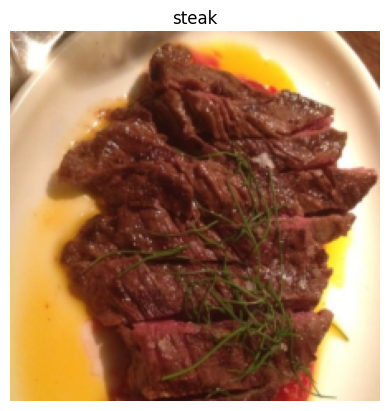

In [13]:
# Visualize a single image
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False);

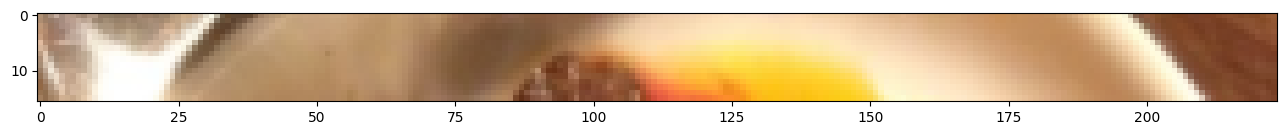

In [14]:
# Change image shape to be compatible with matplotlib
image_permuted = image.permute(1,2,0) # color_channel, height, width -> height, width, color_channel

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size)) 
plt.imshow(image_permuted[:patch_size, :, :])

Number of patches per row: 14.0 
Patch size: 16 pxls x 16 pxls


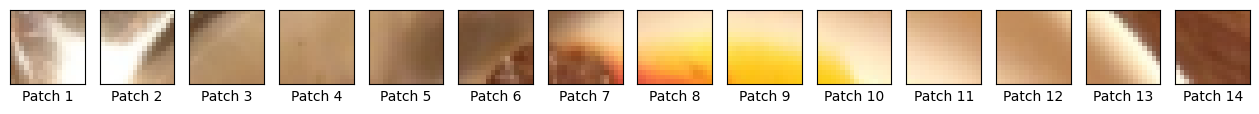

In [15]:
# Setup code to plot the top row as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches} \nPatch size: {patch_size} pxls x {patch_size} pxls")

# Create subplots
fig,axs = plt.subplots(nrows=1,
                    ncols= img_size // patch_size, # one column per patch
                    figsize=(patch_size, patch_size),
                    sharex=True,
                    sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[0:patch_size, patch:patch+patch_size, :]) # plot the patch
    axs[i].set_xlabel(f"Patch {i+1}") # set the xlabel
    axs[i].set_xticks([]) # remove x ticks
    axs[i].set_yticks([]) # remove y ticks

Number of patches per row: 14.0    
Number of patches per column: 14.0    
Total Patches: 196.0    
Patch size: 16 pxls x 16 pxls


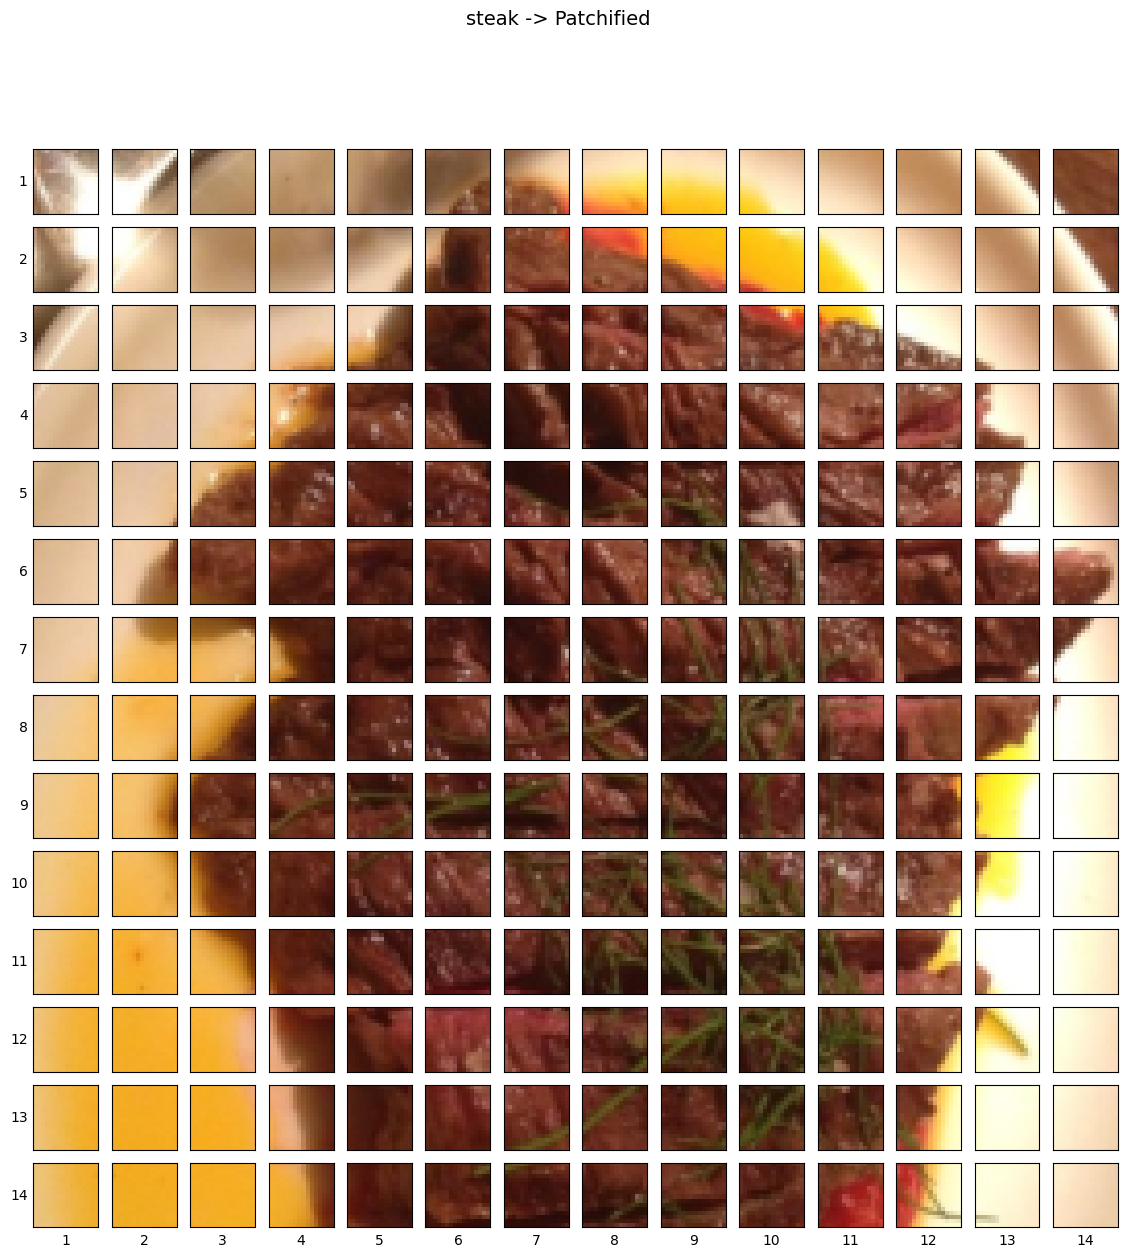

In [21]:
# Setup code to plot the whole image as patches
img_size = 224
patch_size = 16
num_patches = img_size / patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
    \nNumber of patches per column: {num_patches}\
    \nTotal Patches: {num_patches * num_patches}\
    \nPatch size: {patch_size} pxls x {patch_size} pxls")

# Create subplots
fig,axs = plt.subplots(nrows= img_size // patch_size,
                    ncols= img_size // patch_size, # one column per patch
                    figsize=(num_patches, num_patches),
                    sharex=True,
                    sharey=True)

# Loop through height and width of the image and plot patches
for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
        # Plot the permuted image in different axes
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, #iterate through height
                                        patch_width:patch_width+patch_size, #iterate through width
                                        : ]) # all color channels
        # Setup label information for each subplots (patch)
        axs[i, j].set_ylabel(i+1, rotation="horizontal", horizontalalignment='right', verticalalignment='center')
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([]) # remove x ticks
        axs[i, j].set_yticks([]) # remove y ticks
        axs[i, j].label_outer() # only show outer labels
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=14)
plt.show()